# Практическое задание по курсу ОМО: Бустинг (Insurance-Cross-Selling-Classification)

Студент: Горюнов Максим Юрьевич
Группа: 5030102/10201

__Цель__ - предсказать, какие клиенты положительно отреагируют на предложение по автострахованию.

__Модель:__ XGBoost

__Должно быть выполнено:__
1) Исследовательский анализ данных (EDA)
2) Предварительная обработка данных
3) Построение и оценка модели

## Решение

### Описание используемой модели

XGBoost (eXtreme Gradient BOOSTing) – это мощный ансамблевый (использующий набор более слабых предикторов для улучшения результата) метаалгоритм машинного обучения, который основан на методе градиентного бустинга и является его усовершенствованием. Он используется для решения задач классификации и регрессии и стал популярным благодаря своей высокой производительности и эффективности.

Основные характеристики XGBoost:

1. Высокая производительность: XGBoost часто показывает лучшие результаты на соревнованиях по машинному обучению. Это возможно благодаря применению метода градиентного бустинга: каждое новое строящееся дерево в первую очередь ориентируется на примеры, неверно обработанные на предыдущем этапе.

2. Регуляризация: Он штрафует сложные модели, используя как регуляризацию LASSO (L1), так и Ridge-регуляризацию (L2), для того, чтобы избежать переобучения.

3. Работа с разреженными данными: Алгоритм упрощает работу с разреженными данными, в процессе обучения заполняя пропущенные значения в зависимости от значения потерь. К тому же, он позволяет работать с различными узорами разреженности.

4. Параллельные вычисления: Он поддерживает параллельные вычисления, что ускоряет процесс обучения.

5. Расширяемость: Имеет возможность добавления пользовательских функций для расширения функционала (не используется в данном случае, однако является важной характеристикой в целом).


### Исследовательский анализ данных (EDA)

Импортируем библиотеки для анализа данных, разбиения выборки и визуализации:

In [21]:
from xgboost import XGBClassifier, plot_importance
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Описание библиотек:
- xgboost - сама библиотека, содержащая реализованный алгоритм XGBoost.
- numpy - работа с массивами разной размерности. Типы из numpy также используются в pandas.
- pandas - библиотека для обработки и удобной работы с табличными данными, импортирования данных в разных форматах, включая CSV.
- matplotlib, seaborn - библиотеки визуализации данных.
- sklean - оценка результативности модели и разбиение выборки на обучающую и тестовую.

Загрузим используемые данные,посмотрим, какие параметры содержатся в выборке и посчитаем отсутствующие значения:

In [2]:
all_data = pd.read_csv('data.csv')

In [3]:
print(all_data.info(show_counts=True))
print(all_data.head())
print(all_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   id                    11504798 non-null  int64  
 1   Gender                11504798 non-null  object 
 2   Age                   11504798 non-null  int64  
 3   Driving_License       11504798 non-null  int64  
 4   Region_Code           11504798 non-null  float64
 5   Previously_Insured    11504798 non-null  int64  
 6   Vehicle_Age           11504798 non-null  object 
 7   Vehicle_Damage        11504798 non-null  object 
 8   Annual_Premium        11504798 non-null  float64
 9   Policy_Sales_Channel  11504798 non-null  float64
 10  Vintage               11504798 non-null  int64  
 11  Response              11504798 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB
None
   id  Gender  Age  Driving_License  Region_Code  Previously_I

Малое количество параметров позволяет вручную проверить и убедиться в том, что имеющаяся выборка не содержит пустых (null) значений, что видно из подсчетов ненулевых значений по каждому из параметров и их сравнению с общим числом элементов выборки.

Посмотрим, как распределена целевая переменная (`Response`):

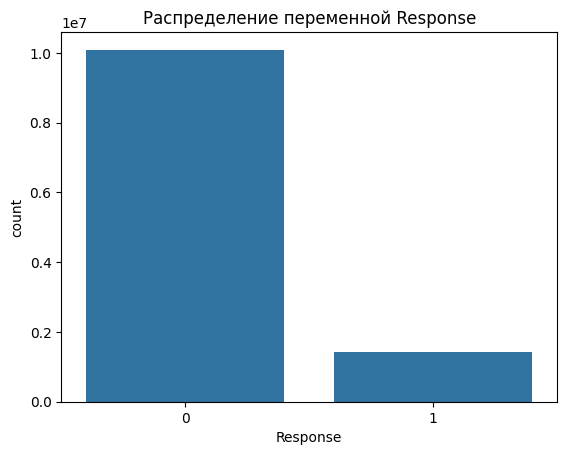

In [4]:
sns.countplot(x='Response', data=all_data)
plt.title('Распределение переменной Response')
plt.show()

Построенная гистограмма показывает, что данные распределены неравномерно. Для правильного обучения модели необходимо учесть этот факт при разбиении выборки на обучающую и тестовую.

Далее необходимо осуществить процесс отбора переменных (feature selection), наиболее влияющих на результирующую. Для этого построим корреляционную матрицу, предварительно переведя категориальные признаки в численные, и визуализируем ее:

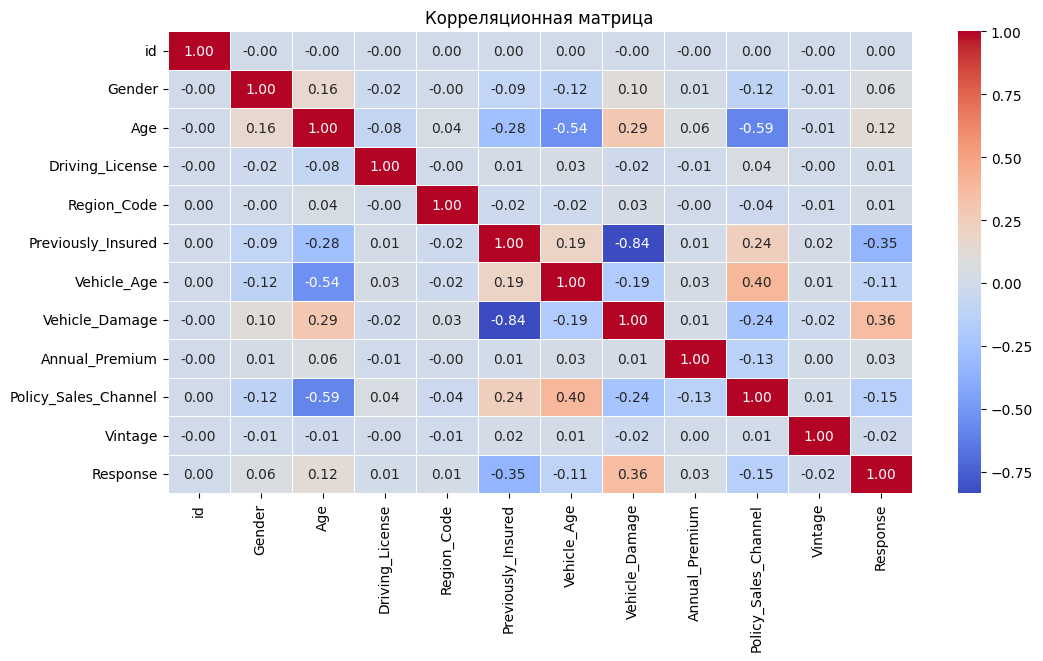

In [6]:
cat_features = all_data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in cat_features:
    all_data[col] = encoder.fit_transform(all_data[col])

numerical_features = all_data.select_dtypes(include=['number'])
corr = numerical_features.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:
- целевая переменная Response наиболее сильно скоррелирована с переменными Previously_Insured, Vehicle_Damage
- Response имеет слабую корреляцию с переменными Age, Vehicle_Age и Policy_Sales_Channel
- при этом переменные Previously_Insured и Vehicle_Damage имеют значительную корреляцию между собой. Вообще говоря, коллинеарность данных переменных может привести к ухудшению качества обучения модели (задача оказывается плохо поставлена - ill-posed), но ввиду того, что алгоритм XGBoost самостоятельно обеспечивает регуляризацию, обе переменные будут оставлены в выборке, чтобы алгоритм произвел отбор значащего признака.
**Дополнение**: в варианте обучения модели, который не учитывает переменную `Previously_Insured` и который не вошел в итоговый отчет, оценки оказались ниже, чем в итоговом. Таким образом, решение оставить обе переменные для обучения модели оказалось верным.

### Предобработка данных

Для обучения модели требуется перевести категориальные данные в индикаторные переменные, получив для каждой старой переменной столько новых переменных, сколько значений она может принимать (например, 2 новых колонки для признака Age):

In [7]:
dummy_data = pd.get_dummies(all_data, drop_first=True)

Ввиду крайне значительного преобладания объектов класса 0 над объектами класса 1, можно прибегнуть части объектов класса 0 для того, чтобы выборки стали более сбалансированными:

In [8]:
class_0 = dummy_data[dummy_data['Response'] == 0]
class_1 = dummy_data[dummy_data['Response'] == 1]
class_0_sampled = class_0.sample(n=len(class_0) // 2, random_state=42)
balanced_data = pd.concat([class_0_sampled, class_1])
balanced_data = shuffle(balanced_data, random_state=42)

Далее необходимо произвести разбиение выборки для обучения и тестирования. Для обучения оставим только значящие переменные, а итоговую переменную Response переведем в зависимую. Учтем несбалансированность классов посредством параметра `stratify=y`:

In [9]:
# comment if not needed
dummy_data = balanced_data



X = dummy_data.drop(columns=['id', 'Driving_License', 'Region_Code', 'Vintage', 'Response'])
y = dummy_data['Response']

print(X.info())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

<class 'pandas.core.frame.DataFrame'>
Index: 6459928 entries, 8101862 to 11125371
Data columns (total 7 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                int32  
 1   Age                   int64  
 2   Previously_Insured    int64  
 3   Vehicle_Age           int32  
 4   Vehicle_Damage        int32  
 5   Annual_Premium        float64
 6   Policy_Sales_Channel  float64
dtypes: float64(2), int32(3), int64(2)
memory usage: 320.4 MB
None


### Создание и обучение используемой модели

Одним из входных параметров модель `XGBClassifier` принимает веса, с которыми учитываются классы. Посчитаем эти веса как отношение размеров классов и инициализируем модель:

In [10]:
scaling = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scaling)
model = XGBClassifier(scale_pos_weight=scaling)

3.565130246359029


Для обучения модели вызовем:

In [11]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Качество оценки модели произведем за счет вычисления ROC AUC score (площадь под графиком кривой, что будет видно на графике ниже) и ориентируясь на показатели, предоставляемые `classification_report`, в особенности F1 score. Также построим визуализацию ROC значения.

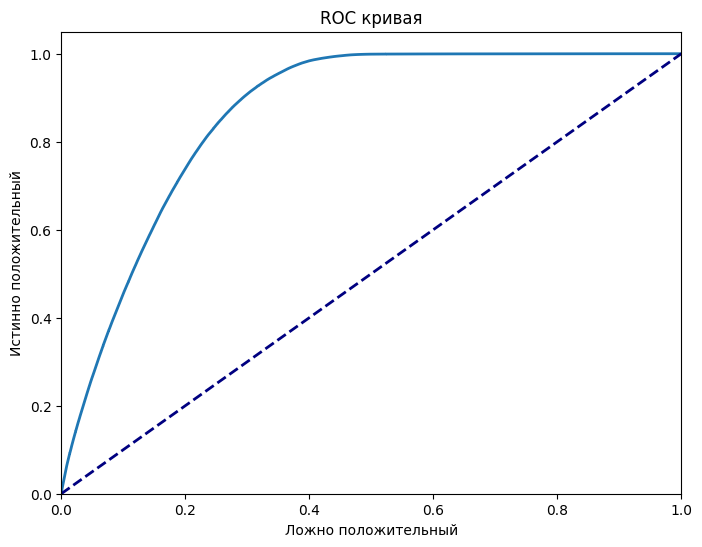

In [22]:
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.title('ROC кривая')
plt.plot(fpr, tpr, lw=2, label=f'ROC AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно положительный')
plt.ylabel('Истинно положительный')
plt.show()

**Дополнение**: до "урезания" объектов класса 0 в количестве F1 score для класса 1 составлял 0.40, что значительно меньше половины. Это связано с тем, что модель переобучается на примерах из класса 0. Эта особенность также будет освещена в выводе.

In [23]:
y_pred = model.predict(X_test)
y_pred_probability = model.predict_proba(X_test)[:, 1]

print("roc auc score:", roc_auc)
print(classification_report(y_test, y_pred))

roc auc score: 0.8638416489113394
              precision    recall  f1-score   support

           0       0.97      0.68      0.80   1008974
           1       0.45      0.93      0.61    283012

    accuracy                           0.74   1291986
   macro avg       0.71      0.80      0.70   1291986
weighted avg       0.86      0.74      0.76   1291986



Смогли добиться высокого показателя ROC AUC (0.86) и достаточно высокого показателя F1. Построим матрицу ошибок для демонстрации соотношений верных и неверных классификаций, выполненных моделью:

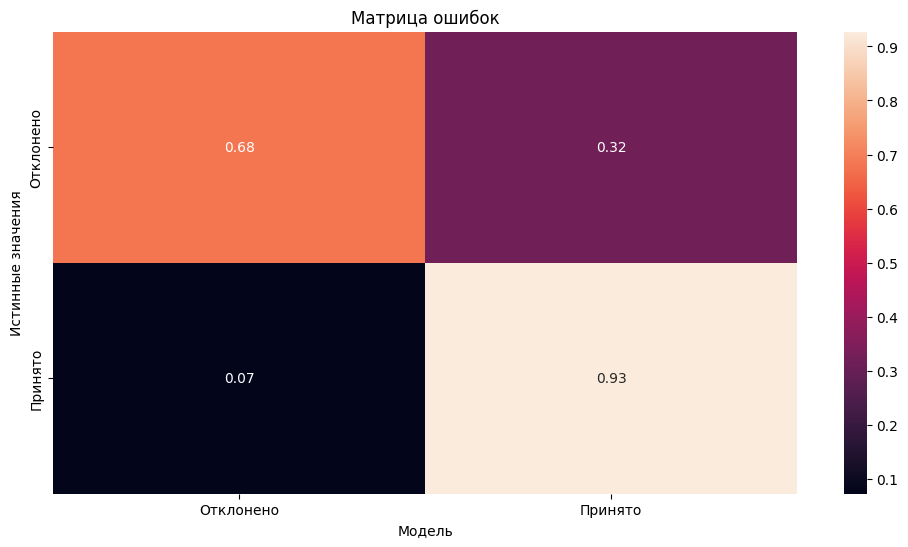

In [24]:
y_pred = model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

labels = ["Отклонено", "Принято"]


plt.figure(figsize=(12, 6))
plt.title('Матрица ошибок')
sns.heatmap(confusion_normalized, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Модель')
plt.ylabel('Истинные значения')
plt.show()

Заметно, что модель очень хорошо отслеживает случаи, когда `Response` положительный, но часто ошибочно записывает отклоненные предложения в принятые (значение матрицы 0.32, правый верхний угол). Тем не менее, сохраняется диагональное преобладание, и нижняя оценка правильной классификации истинных результатов в каждом из классов составляет почти 0.7.

Так как при обучении модели сохранили большое количество признаков, в том числе - сильно скоррелированные между собой и слабо скореллированные с целевой переменной, необходимо оценить важность каждого признака. Так как `XGBoost` является ансамблем решающих деревьев, важность признаков показывает количество раз, когда признак использовался для разделений в деревьях.

<Figure size 1200x600 with 0 Axes>

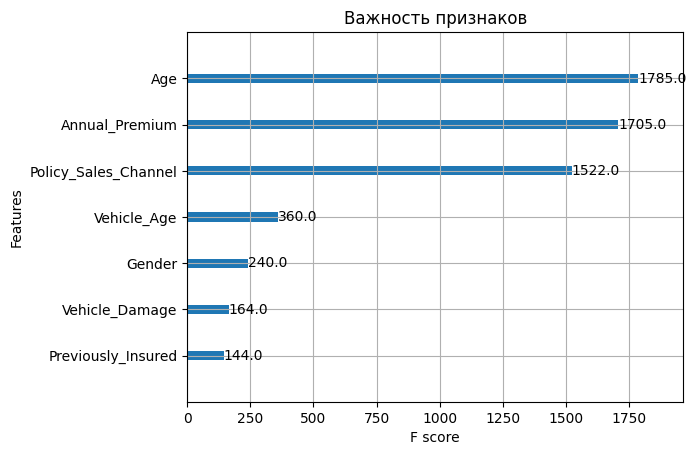

In [26]:
plt.figure(figsize=(12, 6))
plot_importance(model, importance_type='weight')
plt.title('Важность признаков')
plt.show()

Что интересно, наиболее важным признаком является `Age`, хотя эта переменная скоррелирована с целевой всего на 0.12. При этом переменные `Vehicle_Damage` и `Previously_Insured` заняли два последних места. Эти результаты поддаются и логическому обоснованию: возраст клиента будет оказывать сильное влияние на принятие решения о продлении автострахования, так как чем старше клиент, тем больше объем информации, которую он сам учитывает при отклике на предложение. Также влияние оказывает предложение премиальной страховки (`Annual_Premium`), которое может показаться более выгодным многим клиентам.

### Анализ полученных результатов

В рамках проделанной работы была обучена модель `XGBoost` для предсказания принятия решения клиентов о предложении по автострахованию.
Можно сделать следующие выводы:
- Модель `XGBoost` действительно способна самостоятельно проводить регуляризацию сильно скоррелированных переменных.
- Переменные, сильно скоррелированные с результатом, не обязательно оказываются наиболее важными при составлении предсказания.
- Балансировка классов позволяет улучшить предсказательные способности модели для недопредставленного класса. Для улучшения предсказательной способности модели может быть полезно еще более уменьшить количество объектов в преобладающем классе (в данном случае в классе 0). Тем не менее, производя такую операцию, мы рискуем упустить некоторые критически важные данные, так как уменьшение объема выборки класса 0 производится случайным образом.